In [22]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.backend import clear_session

In [23]:
clear_session()

In [24]:
# load vgg16 model
model = InceptionV3(weights='imagenet',include_top=False)
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [25]:
for layer in model.layers:
    layer.trainable = False

In [26]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [27]:
# extract features from image
features = {}
directory = 'Images30k'

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(299, 299))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/31783 [00:00<?, ?it/s]

In [28]:
#With Pretrained
filepath = os.path.join('Save', 'features_30k_pretrained_Inception.pkl')
#Without Pretrained
# filepath = os.path.join('Save', 'features_30k.pkl')

#store features in pickle
pickle.dump(features, open(filepath, 'wb'))
# load features from pickle
with open(filepath, 'rb') as f:
    features = pickle.load(f)

In [29]:
with open("test.csv", 'r') as f:
    next(f)
    captions_doc = f.read()

### Preprocess

In [30]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/158916 [00:00<?, ?it/s]

In [31]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

clean(mapping)

In [32]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

75

In [33]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

### Data generation

In [34]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [35]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

### Model

In [57]:
clear_session()

In [58]:
# # encoder model
# # image feature layers
# inputs1 = Input(shape=(4096,))
# fe1 = Dropout(0.4)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)
# # sequence feature layers
# inputs2 = Input(shape=(max_length,))
# se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# se2 = Dropout(0.4)(se1)
# se3 = LSTM(256)(se2)

# # decoder model
# decoder1 = add([fe2, se3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam')

# # plot the model
# plot_model(model, show_shapes=True)

In [59]:
# encoder model
# image feature layers
inputs1 = Input(shape=(1000,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [80]:
def save_load_weigth(flag ,weights):
    if flag == "save":
        if weights == "InceptionV3":
            model.save_weights("InceptionV.h5")
        elif weights == "VGG16_imagenet":
            model.save_weights("imagenet.h5")
        elif weights == "VGG16":
            model.save_weights("before_eat.h5")
    elif flag == "load":
        if weights == "InceptionV3":
            model.load_weights("InceptionV.h5")
        elif weights == "VGG16_imagenet":
            model.load_weights("imagenet.h5")
        elif weights == "VGG16":
            model.load_weights("before_eat.h5")
    else:
        print("Flag or weights not correct")

In [ ]:
save_load_weigth("load","InceptionV3")

In [61]:
# train the model
epochs = 10
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

446/446 [==============================] - 1421s 3s/step - loss: 3.0324


In [62]:
save_load_weigth("save","InceptionV3")

### Generate Captions

In [63]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [64]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [65]:
clear_session()

In [76]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/3179 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [67]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join( "Images30k", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq two men sit reading books in smoke-filled area next to table holding sweet corn and raw hotdogs endseq
startseq man and boy perhaps father and son at cookout reading together ." endseq
startseq two men are sitting down and reading next to table with food on it endseq
startseq two people are sitting and reading books at cookout endseq
startseq two men sitting in chairs outside near food reading endseq
--------------------Predicted--------------------
startseq man in blue shirt and black pants is riding bike endseq


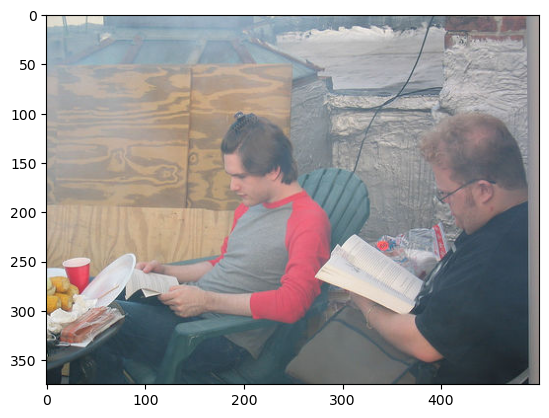

In [75]:
generate_caption("371903.jpg")

---------------------Actual---------------------
startseq statue of wizard holding gnarled staff sits in front of stone wall as small white pale in front suggests an offering endseq
startseq statue of an old bearded beggar wearing pointed hat and holding an ornate stick with collection box in front of him ." endseq
startseq box is in front of likeness of wizard on the street endseq
startseq stone statue of wizard holding his staff endseq
startseq small tub sits in front of the statue endseq
--------------------Predicted--------------------
startseq man in blue shirt and black pants is playing an electric guitar endseq


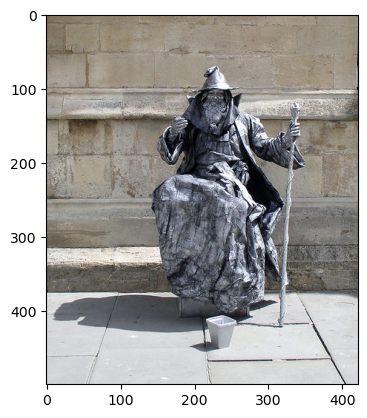

In [78]:
generate_caption("2069887.jpg")

---------------------Actual---------------------
startseq dock workers helping each other straighten out ropes with bridge and ship in the background endseq
startseq group of people on bridge beside boat endseq
startseq three men draping rope across road endseq
startseq group of men are working on the docks endseq
startseq workers with ropes in the street endseq
--------------------Predicted--------------------
startseq man in blue shirt and black pants is standing in front of microphone in front of microphone endseq


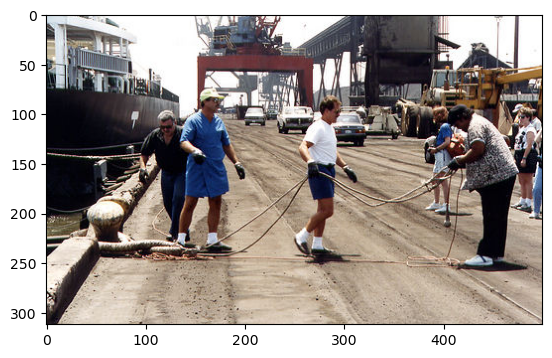

In [70]:
generate_caption("301246.jpg")

---------------------Actual---------------------
startseq skydiver hangs from the undercarriage of an airplane or some sort of air gliding device endseq
startseq person is hanging on to the bottom of an airplane preparing to skydive endseq
startseq person flying in air wearing sandals goggles and wind suit ." endseq
startseq someone is hanging on to plane high up in the air endseq
startseq here is stuntman hanging from helicopter endseq
--------------------Predicted--------------------
startseq man in blue shirt and black pants is playing an electric guitar endseq


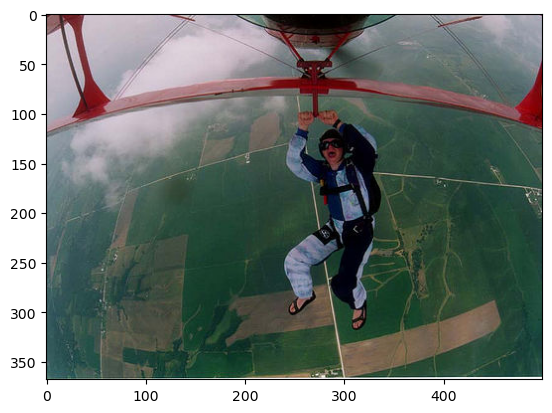

In [71]:
generate_caption("726414.jpg")

---------------------Actual---------------------
startseq the martial artist in white seems to have the upper hand on his older opponent endseq
startseq two men dressed in white uniforms one with black pants are doing karate ." endseq
startseq two men wearing martial arts clothing are practicing martial arts endseq
startseq two men are engaged in karate in an all white room endseq
startseq two martial artists practice in vacant room endseq
--------------------Predicted--------------------
startseq man in blue shirt and black pants is playing an electric guitar endseq


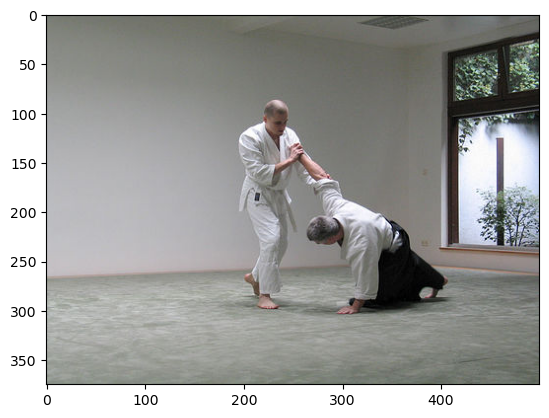

In [72]:
generate_caption("675153.jpg")